In [1]:
import train
import disc_func
import decision_tree
import similarity
import fetch
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# run pip install aif360
from sklearn.model_selection import train_test_split
from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score
import time
from joblib import dump, load



def reload_modules():
    importlib.reload(train)
    importlib.reload(disc_func)
    importlib.reload(decision_tree)
    importlib.reload(similarity)

pip install 'aif360[LawSchoolGPA]'


In [2]:
# Fetch dataset
X, y, Xy, columns, class_names, disc_index = fetch.fraud()
print(disc_index)
# adult, bank, compas (race/sex), german (foreign/sex) , credit(sex/marital), fraud

4


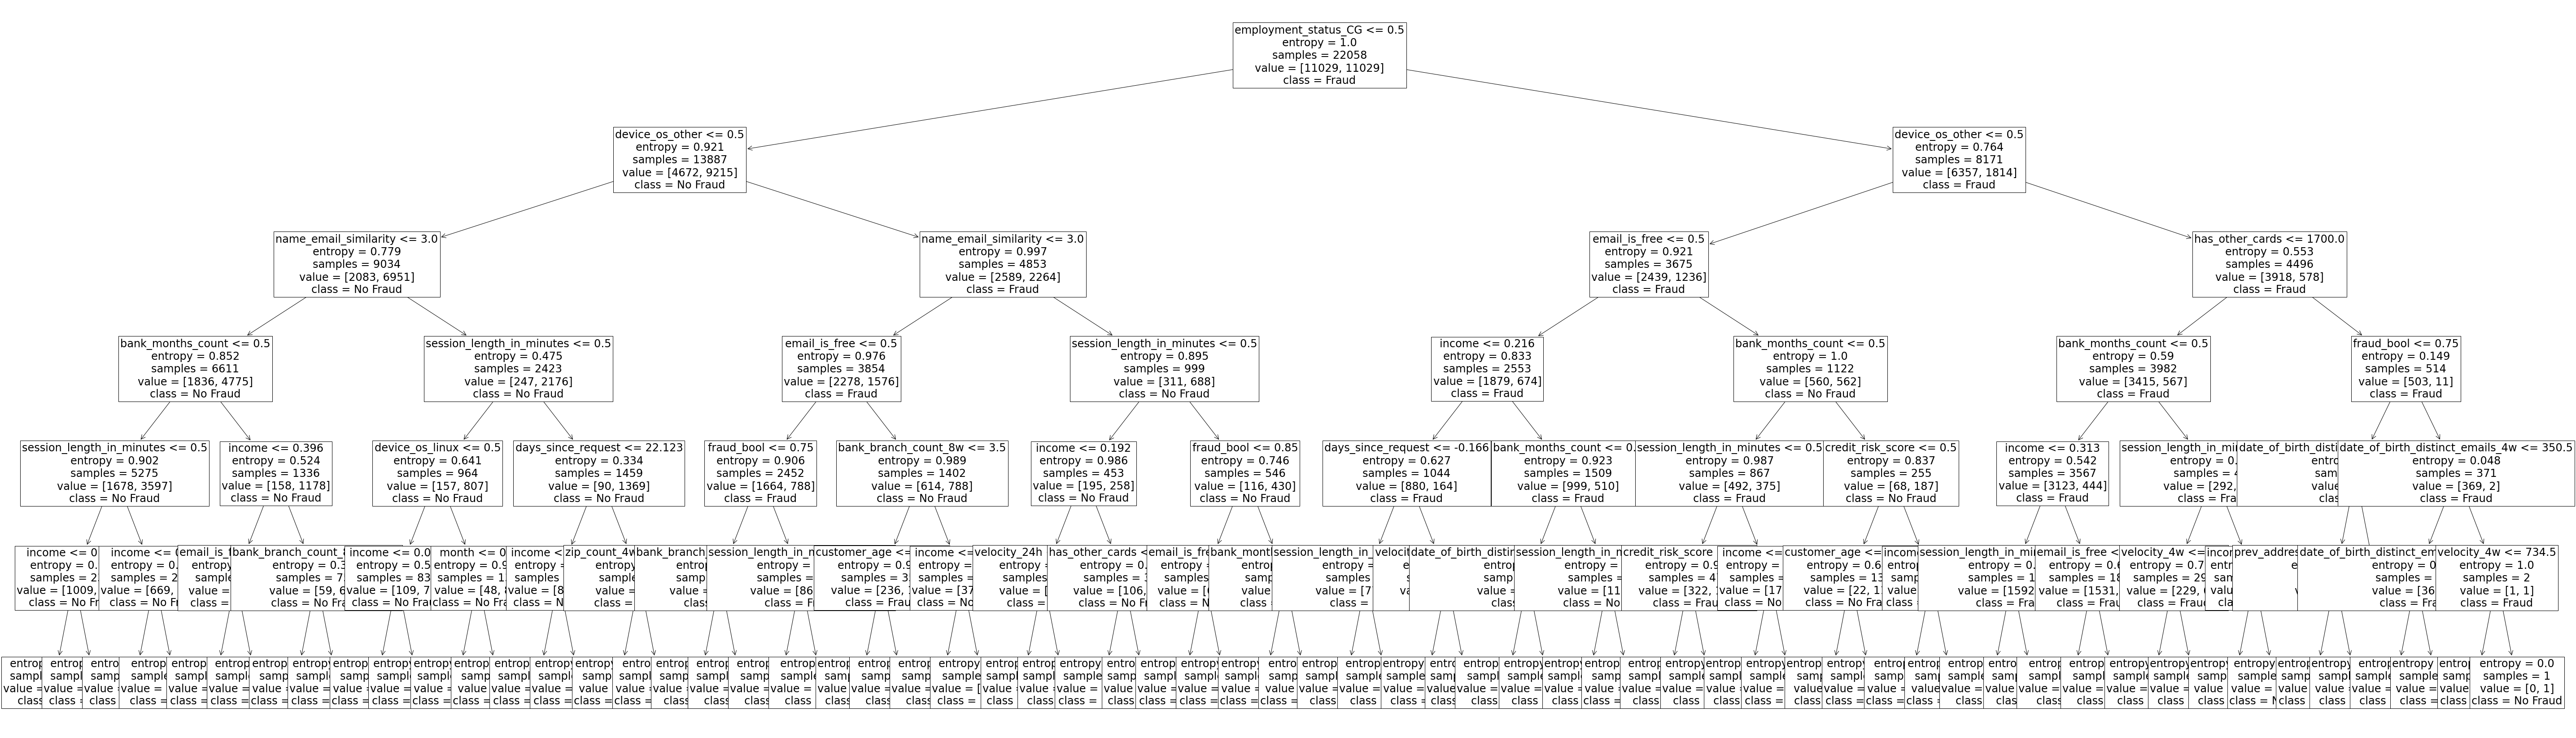

In [3]:
# Create a discriminative (but accurate) tree via sklearn
load_tree = True
if load_tree:
    clf = load('gooddt.joblib')
else:
    clf = tree.DecisionTreeClassifier(max_depth=6, criterion='entropy')
    clf = clf.fit(X, y)
    dump(clf, 'gooddt.joblib')
plt.figure(figsize=(100,30))
tree.plot_tree(clf, fontsize=24, feature_names=columns, class_names=class_names)
plt.show()
tree_dict = decision_tree.export_dict(clf)
for data in Xy:
    tree_dict.add_data(data, disc_index)

# {"discrimination":"-0.25", "accuracy":"0.767","employment_status_CG":"0.5", "Left":{"discrimination":"-0.122", "accuracy":"0.742","device_os_other":"0.5", "Left":{"discrimination":"-0.027", "accuracy":"0.772","name_email_similarity":"3.0", "Left":{"discrimination":"-0.002", "accuracy":"0.722","email_is_free":"0.5", "Left":{"discrimination":"-0.086", "accuracy":"0.658","income":"0.33", "Left":{"discrimination":"-0.031", "accuracy":"0.55","bank_months_count":"0.5", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.004", "accuracy":"0.904","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"-0.076", "accuracy":"0.658","has_other_cards":"745.0", "Left":{"class":1.0}, "Right":{"discrimination":"-0.186", "accuracy":"0.917","zip_count_4w":"7775.1", "Left":{"class":0.0}, "Right":{"class":1.0}}}}}, "Right":{"discrimination":"-0.106", "accuracy":"0.687","name_email_similarity":"3.0", "Left":{"discrimination":"0.007", "accuracy":"0.672","email_is_free":"0.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.214", "accuracy":"0.669","bank_branch_count_8w":"2.5", "Left":{"discrimination":"0.027", "accuracy":"0.735","income":"0.88", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.078", "accuracy":"0.654","income":"0.22", "Left":{"class":0.0}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.12", "accuracy":"0.744","date_of_birth_distinct_emails_4w":"208.0", "Left":{"discrimination":"-0.076", "accuracy":"0.761","income":"0.19", "Left":{"discrimination":"-0.13", "accuracy":"0.626","velocity_4w":"0.5", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.049", "accuracy":"0.809","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"class":0.0}}}, "Right":{"discrimination":"0.018", "accuracy":"0.65","foreign_request":"14.29", "Left":{"discrimination":"0.059", "accuracy":"0.595","bank_months_count":"0.5", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"class":0.0}}}}}, "Right":{"discrimination":"-0.042", "accuracy":"0.811","device_os_other":"0.5", "Left":{"discrimination":"-0.048", "accuracy":"0.736","bank_months_count":"0.5", "Left":{"discrimination":"-0.054", "accuracy":"0.744","session_length_in_minutes":"0.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.095", "accuracy":"0.652","income":"0.18", "Left":{"class":0.0}, "Right":{"discrimination":"-0.091", "accuracy":"0.592","date_of_birth_distinct_emails_4w":"224.5", "Left":{"class":1.0}, "Right":{"class":0.0}}}}, "Right":{"discrimination":"-0.02", "accuracy":"0.697","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.019", "accuracy":"0.644","phone_mobile_valid":"0.0", "Left":{"class":0.0}, "Right":{"discrimination":"0.01", "accuracy":"0.61","has_other_cards":"1750.0", "Left":{"class":1.0}, "Right":{"class":0.0}}}, "Right":{"discrimination":"-0.069", "accuracy":"0.794","income":"0.35", "Left":{"discrimination":"-0.172", "accuracy":"0.692","date_of_birth_distinct_emails_4w":"255.0", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"0.004", "accuracy":"0.87","bank_months_count":"0.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.015", "accuracy":"0.738","session_length_in_minutes":"0.5", "Left":{"discrimination":"0.019", "accuracy":"0.76","date_of_birth_distinct_emails_4w":"241.5", "Left":{"discrimination":"0.038", "accuracy":"0.689","fraud_bool":"0.65", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":0.0}}, "Right":{"discrimination":"-0.009", "accuracy":"0.685","payment_type_AB":"0.5", "Left":{"discrimination":"0.051", "accuracy":"0.655","income":"0.08", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"discrimination":"0.21", "accuracy":"0.8","has_other_cards":"1250.0", "Left":{"class":1.0}, "Right":{"class":0.0}}}}}}}

In [4]:
def retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_calc, disc_func=disc_func.discrimination, criterion='gini'):
    def retrain(dec_tree, bad_node, train_method, disc_func, criterion):
        print('bad node:', bad_node.visual_json(disc_index, disc_func, attributes=columns))
        print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(disc_index))
        # print(tree_dict.data)
        good_node = bad_node.retrain_node(tree_dict.disc_data, depth=2, train_method=train_method, disc_index=disc_index, criterion=criterion, disc_coef=1, acc_coef=1)
        # good_node.simplify()
        print('good node', good_node.visual_json(disc_index, disc_func, attributes=columns))
        for data in bad_node.data:
            good_node.add_data(data[:-1], disc_index)
        print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(disc_index))
        dec_tree_copy = dec_tree.copy()
        if bad_node.unique_id == dec_tree.unique_id:
            dec_tree = good_node
        else:
            parent_node = dec_tree_copy.get_parent(bad_node.unique_id, bad_node.get_height()+1)
            if parent_node == None:
                parent_node = dec_tree_copy.get_parent(bad_node.unique_id)
            parent_node.replace_child(bad_node.unique_id, good_node)
        dec_tree_copy.reset_data()
        for data in Xy:
            dec_tree_copy.add_data(data, disc_index)
        if dec_tree_copy.discrimination(disc_index, disc_func=disc_func) > dec_tree.discrimination(disc_index, disc_func=disc_func):
            dec_tree = dec_tree_copy
        print('\nAccuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')
        return dec_tree, good_node

    dec_tree = tree_dict.copy()
    dec_tree.simplify()
    for data in Xy:
        dec_tree.add_data(data, disc_index)
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))
    print('BEFORE: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')

    trained_nodes = [dec_tree.unique_id]
    if target_method == decision_tree.get_bad_nodes_root_method_bfs or decision_tree.get_bad_nodes_root_method:
        bad_nodes = target_method(dec_tree, threshold=-0.08, timeout=30, top=7, prop_thresh=0.3)
        print('bad_nodes:', bad_nodes)
        print(dec_tree.visual_json(disc_index, disc_func, attributes=columns, highlight=bad_nodes))
    else:
        bad_nodes = target_method(dec_tree, target, disc_index, trained_nodes, disc_func=disc_func)
    if type(bad_nodes) == list:
        for bad_node in bad_nodes:
            if bad_node.unique_id == dec_tree.unique_id:
                continue
            dec_tree, _ = retrain(dec_tree, bad_node, train_method, disc_func, criterion)
    else: 
        while(dec_tree.discrimination(disc_index, disc_func) < target):
            bad_nodes = target_method(dec_tree, target, disc_index, trained_nodes, disc_func=disc_func)
            if bad_nodes == None:
                break 
            # print(bad_nodes.unique_id, trained_nodes, bad_nodes.unique_id in trained_nodes)
            trained_nodes.append(bad_nodes.unique_id)
            # if bad_nodes.discrimination(disc_index, disc_func) > target:
            #     break
            dec_tree, good_node = retrain(dec_tree, bad_nodes, train_method, disc_func, criterion)
            trained_nodes.append(good_node.unique_id)

    print('\nAFTER: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index, disc_func))
    print('predictive similarity:', similarity.predictive_similarity(tree_dict.data, dec_tree.data), 'naive discounted similarity:', similarity.naive_discounted_similarity(tree_dict, dec_tree))
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))
    return dec_tree

In [5]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=-0.05, target_method=decision_tree.get_bad_nodes_root_method_bfs, train_method=train.gain_root, disc_func=disc_func.discrimination, criterion='gini')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",new_tree.discrimination(disc_index, disc_func.discrimination)-tree_dict.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", new_tree.accuracy()-tree_dict.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.275", "accuracy":"0.76","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.734","device_os_other":"0.5", "Left":{"discrimination":"-0.042", "accuracy":"0.77","name_email_similarity":"3.0", "Left":{"discrimination":"-0.028", "accuracy":"0.722","bank_months_count":"0.5", "Left":{"discrimination":"-0.05", "accuracy":"0.682","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.066", "accuracy":"0.591","income":"0.43", "Left":{"class":0.0}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.113", "accuracy":"0.67","name_email_similarity":"3.0", "Left":{"discrimination":"-0.022", "accuracy":"0.656","email_is_free":"0.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.27", "accuracy":"0.653","bank_branch_count_8w":"3.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.052", "accuracy":"0.645","income":"0.17", "Left":{"class":0.0}, "Right":{"class":1.

In [6]:
# start_time = time.time()
# new_tree = retrain_tree(tree_dict, target=-0.1, target_method=decision_tree.get_worst_node, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='gini')
# print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
# print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
# print("Took", time.time()-start_time, 'seconds')

In [7]:
# start_time = time.time()
# new_tree = retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='entropy')
# print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
# print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
# print("Took", time.time()-start_time, 'seconds')